<a href="https://colab.research.google.com/github/nhathpham/Taxi-Fleet-Management/blob/main/taxi_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hdbscan
#!pip install scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039290 sha256=d073375f675011f8b493ae8a53655805f974665ed3692c6187a227cab9d9ce07
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#from hdbscan import HDBSCAN
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
#from sklearn.cluster import HDBSCAN
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
#import hdbscan
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to your Parquet file
file_path = '/content/drive/My Drive/USML Projects/Data/clean_taxi_full.parquet'

df = pd.read_parquet(file_path)
len(df)

Mounted at /content/drive


2864

# **A. Clustering functions**

## **1. Determine best number of clusters**


### 1.1 Elbow method (K-means only)

In [ ]:
def find_k_elbow(X, k_range):
    """
    Find the optimal number of clusters for KMeans using the Elbow Method.
    Parameters:
    - X: Preprocessed dataset
    - k_range: Range of k values to try (e.g., range(1, 11))
    Returns:
    - Optimal k value (elbow point) based on visual inspection
    """
    sse = []  # Sum of squared distances
    for k in k_range:
        #print(k)
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

    plt.figure(figsize=(6, 4))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method for Determining Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of squared distances')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()


### 1.2 Silhouette score (K-means, GMM, Hierarchical)

In [ ]:
# Sample a portion of the data because it takes a long time to run silhouette score on the whole dataset
def sample_dataset(X, sample_size):
    """
    Randomly sample a subset of the dataset.
    Parameters:
    - X: The dataset to be sampled (as a NumPy array or Pandas DataFrame).
    - sample_size: The size of the sample to take. If float, represents the fraction of the dataset to sample.
    Returns:
    - X_sample: A sampled subset of the dataset.
    """
    if isinstance(sample_size, float) and sample_size < 1.0:
        sample_size = int(len(X) * sample_size)
    if isinstance(X, pd.DataFrame):
        X_sample = X.sample(n=sample_size, random_state=42)
    else:  # assuming NumPy array
        indices = np.random.choice(len(X), size=sample_size, replace=False)
        X_sample = X[indices]
    return X_sample

In [ ]:
# higher = better
def find_k_sil_score(X, k_range, model_name, random_state):
    """
    Find the best number of clusters (k) for KMeans based on silhouette score and plot the silhouette scores.
    Parameters:
    - X: Preprocessed dataset
    - k_range: Range of k values to try (e.g., range(2, 11))

    Returns:
    - best_k: The number of clusters k that has the highest silhouette score.
    - silhouette_scores: A list of silhouette scores for each k in k_range.
    """
    silhouette_scores = []
    print("Calculating silhouette scores for different values of k...")
    for k in k_range:
        #print(k)
        if model_name =='kmeans':
            model = KMeans(n_clusters=k, random_state=random_state)
        elif model_name =='GMM':
            model = GaussianMixture(n_components=k, random_state=random_state)
        else: #hierarchical
            model = AgglomerativeClustering(n_clusters=k)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
        #print(f"k = {k}: silhouette score = {score}")
    best_k = k_range[np.argmax(silhouette_scores)]

    # Plotting the silhouette scores
    plt.figure(figsize=(5, 3))
    plt.plot(k_range, silhouette_scores, marker='o', color='orange')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title(f'{model_name}: Silhouette Score by k')
    plt.xticks(k_range)
    plt.grid(False)
    plt.show()

    return best_k, silhouette_scores

### 1.3 BIC score (GMM)

In [ ]:
# lower = better
def find_k_gmm_bic(X, k_range, random_state):
    """
    Find the best number of components for GMM based on BIC.
    Parameters:
    - X: Preprocessed dataset
    - n_components_range: Range of n_components values to try
    Returns:
    - best_k: Optimal number of components with the lowest BIC
    """
    bic_scores = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=random_state)
        gmm.fit(X)
        bic_scores.append(gmm.bic(X))

    plt.figure(figsize=(5, 3))
    plt.plot(k_range, bic_scores, marker='o', color='blue')
    plt.title('GMM: BIC Score by k')
    plt.xlabel('k')
    plt.ylabel('BIC Score')
    plt.xticks(k_range)
    plt.grid(False)
    plt.show()

    best_k = k_range[np.argmin(bic_scores)]
    return best_k

## **2. K-means**

In [ ]:
def apply_kmeans(X, n_clusters, random_state=42):
    """
    Apply KMeans clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Optimal number of clusters determined previously
    Returns:
    - labels: Cluster labels for each data point
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X)
    return kmeans, labels

In [ ]:
def evaluate_kmeans_init(X, n_clusters, random_states):
    """
    Evaluate KMeans clustering for different random states.

    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Optimal number of clusters determined previously
    - random_states: A list of random states for initialization

    Returns:
    - evaluations: A list of dictionaries with each containing the random_state and silhouette_score
    """
    evaluations = []
    for rs in random_states:
        _, labels = apply_kmeans(X, n_clusters, rs)
        silhouette = silhouette_score(X, labels)

        evaluations.append({
            'random_state': rs,
            'silhouette_score': silhouette
        })

    return evaluations

## **3. GMM**

In [ ]:
def apply_gmm(X, n_components, random_state=42):
    """
    Apply Gaussian Mixture Model clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - n_components: Optimal number of components determined previously
    Returns:
    - labels: Cluster labels for each data point
    """
    gmm = GaussianMixture(n_components=n_components, random_state=random_state)
    labels = gmm.fit_predict(X)
    p = gmm.predict_proba(X)
    return labels, p

In [ ]:
def evaluate_gmm_init(X, n_components, random_states):
    evaluations = []
    for rs in random_states:
        labels, probabilities = apply_gmm(X, n_components, rs)
        assigned_probabilities = np.array([probabilities[i, label] for i, label in enumerate(labels)])
        avg_probability = np.mean(assigned_probabilities)
        # Need to refit GMM to compute AIC, BIC due to scikit-learn's API limitations
        gmm = GaussianMixture(n_components=n_components, random_state=rs).fit(X)
        aic = gmm.aic(X)
        bic = gmm.bic(X)
        silhouette = silhouette_score(X, labels)

        evaluations.append({
            'random_state': rs,
            'average_probability': avg_probability,
            'aic': aic,
            'bic': bic,
            'silhouette_score': silhouette
        })

    return evaluations

## **4. Agglomerative Hierarchical**

In [ ]:
def apply_agglomerative(X, n_clusters, metric, linkage):
    """
    Apply Agglomerative Hierarchical clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Optimal number of clusters determined previously
    Returns:
    - labels: Cluster labels for each data point
    """
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, metric=metric, linkage=linkage)
    labels = agglomerative.fit_predict(X)
    return labels

In [ ]:
def evaluate_agg(X, n_clusters, metrics, linkages):
    """
    Evaluate Agglomerative Hierarchical clustering with different metrics and linkages.

    Parameters:
    - X: Preprocessed dataset
    - n_clusters: Number of clusters
    - metrics: List of metrics to compute the linkage
    - linkages: List of linkage criteria to use

    Returns:
    - A list of tuples containing (metric, linkage, silhouette score) for each combination
    - The best combination and its silhouette score
    """
    evaluation_results = []
    for metric in metrics:
        for linkage in linkages:
            # 'ward' linkage only works with 'euclidean' metric
            if linkage == 'ward' and metric != 'euclidean':
                continue
            labels = apply_agglomerative(X,n_clusters=n_clusters, metric=metric, linkage=linkage)
            score = silhouette_score(X, labels, metric=metric)
            evaluation_results.append((metric, linkage, score))

    # Identify the best combination
    best_combination = max(evaluation_results, key=lambda x: x[2])
    return evaluation_results, best_combination

In [ ]:

from collections import Counter

def cluster_balance(labels):
    """Calculate a balance score for clusters, lower is better."""
    cluster_sizes = Counter(labels)
    max_size = max(cluster_sizes.values())
    min_size = min(cluster_sizes.values())
    # Simple balance metric: ratio of sizes of the smallest to the largest cluster
    balance = min_size / max_size
    return balance

def evaluate_with_balance(X, n_clusters, metrics, linkages):
    best_score = -1
    best_combination = None
    best_balance = 0
    for metric in metrics:
        for linkage in linkages:
            if linkage == 'ward' and metric != 'euclidean':
                continue
            labels = apply_agglomerative(X, n_clusters, metric, linkage)
            score = silhouette_score(X, labels)
            balance = cluster_balance(labels)
            # Consider both silhouette score and balance; adjust weighting as needed
            combined_score = score * balance  # Example of combining the two criteria
            if combined_score > best_score or (combined_score == best_score and balance > best_balance):
                best_score = combined_score
                best_combination = (metric, linkage)
                best_balance = balance
    return best_combination, best_score, best_balance

## **5. HDBSCAN**

In [ ]:
def apply_hdbscan(X, min_cluster_size=15, metric = 'euclidean', algorithm = 'auto', min_samples=None):
    """
    Apply HDBSCAN clustering to the dataset.
    Parameters:
    - X: Preprocessed dataset
    - min_cluster_size: The minimum size of clusters; smaller clusters will be considered noise.
    - min_samples: The number of samples in a neighborhood for a point to be considered a core point. If none, set to min_cluster_size
    Returns:
    - labels: Cluster labels for each data point
    """
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples,
                                metric=metric,
                                algorithm=algorithm,
                                cluster_selection_method='eom')
    labels = clusterer.fit_predict(X)
    return labels

## **6. Cluster EDA**

In [ ]:
def boxplot(df, cluster_col, col_name, title, ylabel=None, show_outliers=False):
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=cluster_col, y=col_name, data=df, showfliers=show_outliers)
    plt.title(title)
    plt.xlabel('Cluster')
    if ylabel==None:
      plt.ylabel(col_name)
    plt.ylabel(ylabel)
    plt.show()

In [ ]:
def compare_table(df,cluster_col):
  display(df.groupby(cluster_col)[region_cols].median())
  display(df.groupby(cluster_col)[time_cols].median())
  display(df.groupby(cluster_col)[pay_cols].median())
  display(df.groupby(cluster_col)[['daily_payment','daily_miles']].median())
  display(df.groupby(cluster_col)[['ct_pickup_ca','ct_dropoff_ca']].median())
  #display(df.groupby(cluster_col)[['median_pct_tips']].median())
  #display(df.groupby(cluster_col)[['weekend_to_weekday_ratio']].median())
  display(df.groupby(cluster_col)[rev_cols].median())


In [ ]:
def top_ca_dict(df, group_col, value_cols, top_n):
    """
    Calculate the top N columns by median value for each group in a DataFrame,
    including the median values, with simplified column names.

    Parameters:
    - df: DataFrame to process.
    - group_col: Column name to group by.
    - value_cols: List of columns to calculate medians for.
    - top_n: Number of top columns to return for each group, including their median values.

    Returns:
    - A dictionary with the top N columns (with simplified names) and their median values for each group.
    """
    # Calculate medians for each group
    median_df = df.groupby(group_col)[value_cols].median()

    # Define the prefix to remove
    prefix_to_remove = 'pickup_ca_name_'

    # For each cluster, find the top N columns by median value and include those values
    top_columns = {}
    for cluster in median_df.index:
        top_vals = median_df.loc[cluster].nlargest(top_n)
        # Simplify column names by removing the specified prefix and replace it with nothing
        simplified_names = {col.replace(prefix_to_remove, ''): val for col, val in top_vals.items()}
        top_columns[cluster] = simplified_names
    return top_columns

In [ ]:
# Function to create bar graphs for each cluster's top 10 CA columns with the same x-axis range
def plot_top_ca(ca_top_dict, max_value):
    for cluster, ca_dict in ca_top_dict.items():
        # Prepare data for plotting
        ca_names = list(ca_dict.keys())
        ca_values = list(ca_dict.values())

        # Create bar graph
        plt.figure(figsize=(5, 3))
        plt.barh(ca_names, ca_values, color='skyblue')
        plt.xlabel('Median Value')
        plt.ylabel('Community Area')
        plt.title(f'Top 10 Community Areas for Cluster {cluster}')
        plt.xlim(0, max_value)  # Set the same x-axis range for all plots
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
        plt.show()

In [ ]:
def plot_top_ca_1c(ca_top_dict, cluster, max_value, title, xlabel, ylabel):
    # Get the CA dictionary for the specified cluster
    ca_dict = ca_top_dict.get(cluster, None)
    if ca_dict is None:
        print(f"No data found for cluster {cluster}")
        return

    # Prepare data for plotting
    ca_names = list(ca_dict.keys())
    ca_values = list(ca_dict.values())

    # Create bar graph
    plt.figure(figsize=(4, 2))
    bars = plt.barh(ca_names, ca_values, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim(0, max_value+0.08)  # Set the same x-axis range for all plots
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

    for bar, value in zip(bars, ca_values):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}',
                 va='center', ha='left', color='black')
    plt.show()

# **B. Filter data (baseline and outlier removed)**

1. 'median_idle_seconds':  Indicates efficiency in terms of downtime between trips.
2. 'median_daily_use_rate': proportion of time taxis are active, which is a direct measure of efficiency.
3. 'median_trips_per_day': reflects the volume of business and operational capacity
4. median_daily_payment: reflects financial outcomes
5. 'median_payment_per_trip': measure of revenue efficiency per service, also indicate distance per trip
6. 'median_pct_tips': extreme values may service quality and customer satisfaction
7. 'median_avg_speed_mph': Indicates routing efficiency

In [ ]:
# Assuming df is your pandas DataFrame with the 'median_idle_seconds' column
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.15)
    Q3 = df[column].quantile(0.85)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #print(lower_bound)
    #print(upper_bound)
    # Filter out the outliers
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

In [ ]:
# Define a mapping of original column names to shorter names
column_mapping = {
    'median_idle_seconds': 'idle_time',
    'median_daily_use_rate': 'daily_use_rate',
    'median_trips_per_day': 'trips_per_day',
    'median_daily_payment': 'daily_payment',
    'median_avg_speed_mph': 'avg_speed',
    'median_pct_tips': 'tips_proportion',
    'median_daily_miles': 'daily_mile'
}
# Rename the columns of df_op using the mapping
df.rename(columns=column_mapping, inplace=True)
op_cols_base = ['idle_time','daily_use_rate','trips_per_day',
           'daily_payment', 'avg_speed', 'tips_proportion']

op_cols = ['idle_time','daily_use_rate','trips_per_day',
           'daily_payment', 'avg_speed']

# Get baseline and final dataframes

df_final = df[df.record_error_rate<=0.85]
df_final = remove_outliers(df_final, 'idle_time')

df_op_base = df[op_cols_base]
df_op = df_final[op_cols]

print("Raw df length:", len(df))
print("Base df length:", len(df_op_base))
print("Final df length:", len(df_op))

Raw df length: 2864
Base df length: 2864
Final df length: 2643


### (Only for presentation)

In [ ]:
df.columns = df.columns.str.replace('payment_type', 'pay')
df.columns = df.columns.str.replace('period_start_', '')
df.columns = df.columns.str.replace('pickup_region', 'pickup')
df.columns = df.columns.str.replace('pickup_ca_name', 'ca')

In [ ]:
selected_cols=['taxi_id']+op_cols+['pay_cash','pay_mobile','morning_rush','midday','afternoon','pickup_north','pickup_central','ca_ohare','ca_lake_view','ca_chatham']
df_selected = df[selected_cols].tail(3).round(3)
df_selected['daily_payment'] = df_selected['daily_payment'].round(1)
df_selected

,taxi_id,idle_time,daily_use_rate,trips_per_day,daily_payment,avg_speed,pay_cash,pay_mobile,morning_rush,midday,afternoon,pickup_north,pickup_central,ca_ohare,ca_lake_view,ca_chatham
2861,ffa4a7ea614ef7d2eac427f6f1a0af6a5298a57224da0b...,4500.0,0.270,4.0,186.5,21.224,0.149,0.194,0.050,0.139,0.154,0.035,0.299,0.592,0.015,0.0
2862,ffc2a618ad19a63fa5e9ce8b1bd68656172b2eac505f0a...,2700.0,0.295,4.0,200.7,17.255,0.357,0.200,0.139,0.164,0.197,0.114,0.410,0.395,0.099,0.0
2863,ffd231d2536b9463d888cfbb42f36d543b37d22d96a6dd...,1800.0,0.348,2.5,68.7,10.595,0.399,0.246,0.162,0.105,0.162,0.026,0.579,0.123,0.000,0.0


In [ ]:
# Define prefixes for each category
region_prefix = 'pickup_region'
ca_prefix = 'pickup_ca_name'
time_prefix = 'period_start'
pay_prefix = 'payment_type'
all_columns = df.columns.tolist()

# Generate lists based on column prefixes
region_cols = [col for col in all_columns if col.startswith(region_prefix)]
ca_cols = [col for col in all_columns if col.startswith(ca_prefix)]
#ca_cols = ca_cols+ ['ct_pickup_ca','ct_dropoff_ca']
time_cols = [col for col in all_columns if col.startswith(time_prefix)]
pay_cols = [col for col in all_columns if col.startswith(pay_prefix)]
rev_cols=['total_payment','ct_trips']

# **C. Baseline model**

## **1. Feature scaling**

In [ ]:
from sklearn.preprocessing import RobustScaler
print(len(df_op_base))
scaler = RobustScaler()
X_op_base = pd.DataFrame(scaler.fit_transform(df_op_base), columns=op_cols_base)

2864


## **2. Run GMM**

### 2.1 Choose n

Calculating silhouette scores for different values of k...


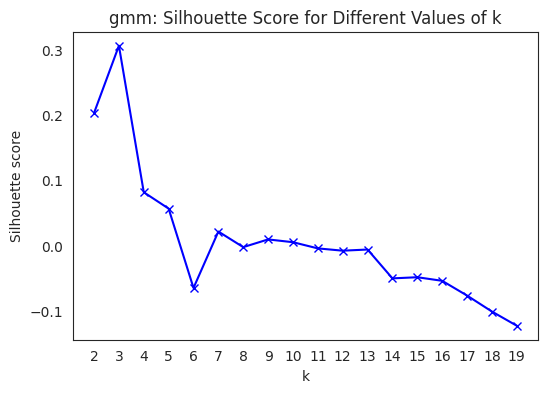

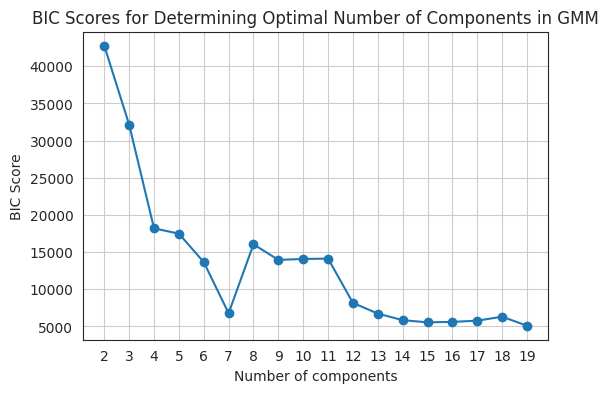

19

In [ ]:
# Silhouette score (higher = better)
best_k, silhouette_scores = find_k_sil_score(X_op_base, range(2, 20), model_name='gmm', random_state=2021)
# BIC (lower = better)
find_k_gmm_bic(X_op_base, range(2, 20), random_state=3242)

### 2.2 Run GMM

In [ ]:
# Pick the best random state
random_states = [42, 739, 2021, 10, 3242, 2, 4, 122]  # Example random states for initialization
n_components = 4

evaluations = evaluate_gmm_init(X_op_base, n_components, random_states)

# Analyzing results to find the best initialization based on chosen criteria
best_by_bic = min(evaluations, key=lambda x: x['bic'])
print("Best model by BIC:", best_by_bic)
#print("Evaluations:", evaluations)

Best model by BIC: {'random_state': 3242, 'average_probability': 0.9815130840789665, 'aic': 17535.436043385154, 'bic': 18196.993216002094, 'silhouette_score': 0.0815005219480611}


In [ ]:
labels, p = apply_gmm(X_op_base, n_components=n_components, random_state=3242) #  #10 #2021
df_op_base['cluster_gmm'] = labels
df['cluster_gmm'] = labels
df_op_base.groupby('cluster_gmm').size()

cluster_gmm
0    1498
1     857
2     371
3     138
dtype: int64

In [ ]:
df_op_base.head()

,idle_time,daily_use_rate,trips_per_day,daily_payment,avg_speed,tips_proportion,cluster_gmm
0,1800.0,0.384875,10.0,218.775,3.00000,0.171053,1
1,2700.0,0.235493,10.0,387.805,9.32855,0.166667,0
2,900.0,0.451276,18.0,227.770,8.47710,0.194040,1
3,7200.0,0.329254,2.0,95.875,30.64290,0.168233,2
4,3600.0,0.272670,5.0,171.725,3.00000,0.168467,2


### 2.3 Cluster EDA

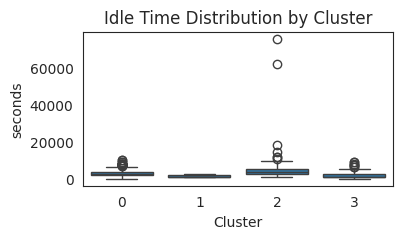

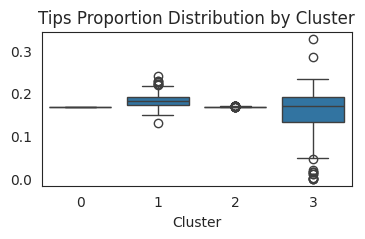

In [ ]:
boxplot(df, 'cluster_gmm', 'idle_time', 'Idle Time Distribution by Cluster', ylabel='seconds', show_outliers=True)
boxplot(df, 'cluster_gmm', 'tips_proportion', 'Tips Proportion Distribution by Cluster', ylabel='', show_outliers=True)

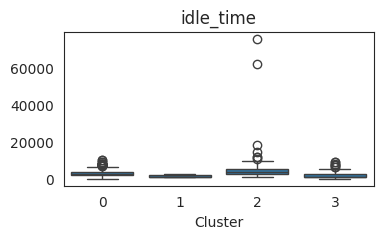

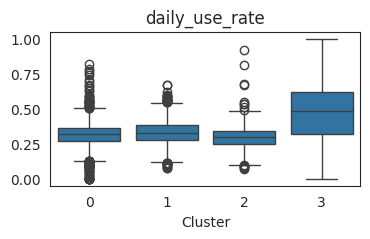

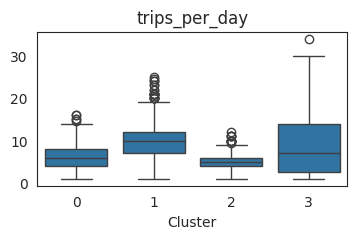

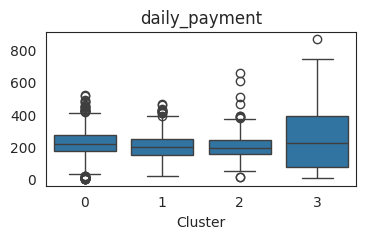

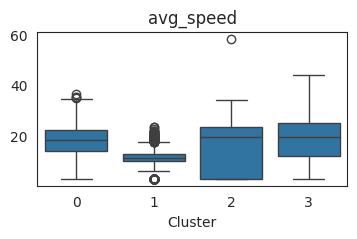

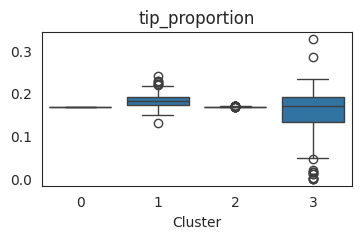

In [ ]:
for col in op_cols_base:
    boxplot(df, 'cluster_gmm', col, col, None, show_outliers=True)

In [ ]:
display(df_op_base.groupby('cluster_gmm')[op_cols].median())
display(df.groupby('cluster_gmm')['median_miles_per_trip'].median())
display(df.groupby('cluster_gmm')['median_pct_tips'].median())
#display(df.groupby('cluster_gmm')['record_error_rate'].median())

,median_idle_seconds,median_daily_use_rate,median_trips_per_day,median_daily_payment,median_avg_speed_mph,median_pct_tips
cluster_gmm,,,,,,
0,2700.0,0.316953,6.0,220.6875,18.52430,0.166667
1,900.0,0.329630,10.0,198.1600,11.20000,0.181818
2,3600.0,0.298810,5.0,195.4500,19.50000,0.168174
3,900.0,0.486472,7.0,226.6750,19.51125,0.169107


cluster_gmm
0    8.475
1    1.970
2    9.800
3    9.610
Name: median_miles_per_trip, dtype: float64

cluster_gmm
0    0.166667
1    0.181818
2    0.168174
3    0.169107
Name: median_pct_tips, dtype: float64

# **D. Final model**


## **1. Visualize data**

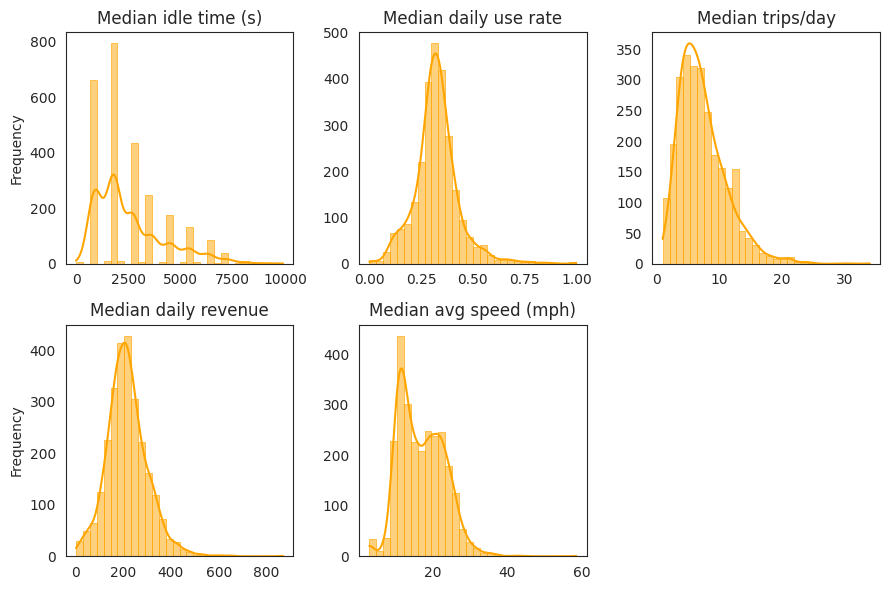

In [ ]:
# Set the seaborn style to white
sns.set_style("white")
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))  # Adjust the figure size as needed

# Flatten the array of axes
axs = axs.flatten()
# Loop through the columns and plot
for i, col in enumerate(op_cols):
    sns.histplot(df_op[col], kde=True, color="orange", bins=30, edgecolor='orange', ax=axs[i])
    axs[i].set_xlabel('')
    if i % 3 == 0:  # Set y-axis label only for the first subplot in each row
      axs[i].set_ylabel('Frequency')
    else:
        axs[i].set_ylabel('')

# Custom titles for each subplot
titles = ['Median idle time (s)', 'Median daily use rate', 'Median trips/day', 'Median daily revenue', 'Median avg speed (mph)']
# Hide the 6th subplot (as we have only 5 plots)
axs[-1].set_visible(False)
for ax, title in zip(axs, titles):
    ax.set_title(title)

plt.tight_layout()
plt.show()

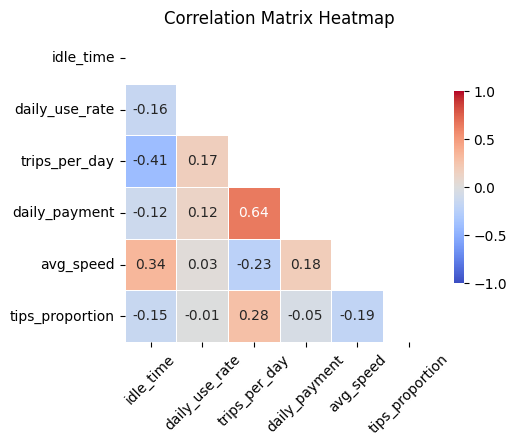

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df_op_base.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(5, 5))

# Draw the heatmap with the masked upper triangle
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .5}, linewidths=.5, vmin=-1, vmax=1)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45)
plt.title('Correlation Matrix Heatmap')
plt.show()

## **2. Feature scaling**

In [ ]:
scaler = StandardScaler()
# Fit and transform the financial data columns
X_op = pd.DataFrame(scaler.fit_transform(df_op), columns=op_cols)

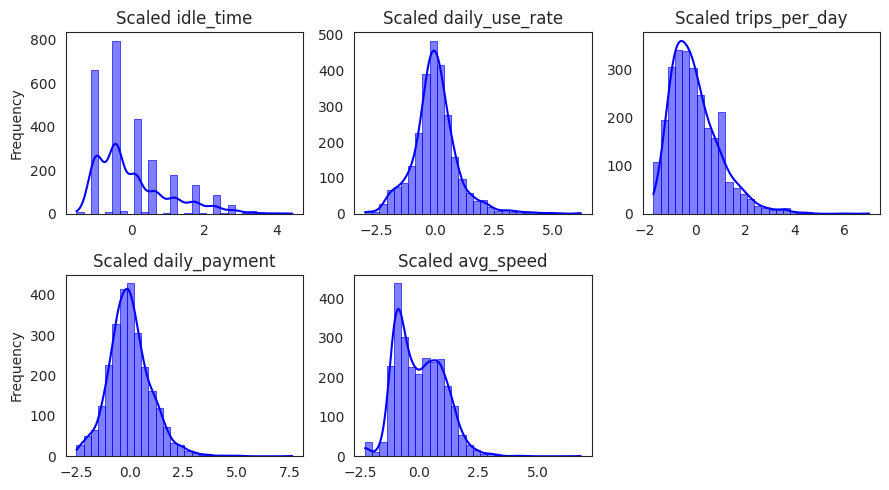

In [ ]:
# Set the seaborn style to white
sns.set_style("white")

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols= 3, figsize=(9, 5)) #len(X_op.columns)

# Flatten the array of axes
axs = axs.flatten()

# Loop through the columns and plot
for i, col in enumerate(X_op.columns):
    sns.histplot(X_op[col], kde=True, color="blue", bins=30, edgecolor='blue', ax=axs[i])
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(f'Scaled {col}')
    if i % 3 == 0:  # Set y-axis label only for the first subplot in each row
      axs[i].set_ylabel('Frequency')
    else:
      axs[i].set_ylabel('')
axs[-1].set_visible(False)
plt.tight_layout()
plt.show()

## **3. K-means**

### 3.1 Run models

In [ ]:
# Choose K
# Elbow method
find_k_elbow(X_op, range(2, 20))
# Silhouette score
best_k, silhouette_scores = find_k_sil_score(X_op, range(2, 20), model_name='kmeans')

In [ ]:
random_states = [42, 739, 2021, 10, 3242, 2, 4, 122]
n_clusters = 3
evaluations = evaluate_kmeans_init(X_op, n_clusters, random_states)

# Print evaluations
for eval in evaluations:
    print(f"Random State: {eval['random_state']}, Silhouette Score: {eval['silhouette_score']}")

In [ ]:
best_k = 3
kmeans, labels = apply_kmeans(X_op, best_k, random_state=42)
df_op['cluster_kmeans'] = labels
#df_lesserror['cluster_kmeans'] = labels
df_op['cluster_kmeans'].value_counts()

### 3.2 EDAs

In [ ]:
for col in op_cols:
  boxplot(df_op, 'cluster_kmeans', col, col)

In [ ]:
compare_table(df_lesserror, 'cluster_kmeans')

## **4. GMM**

### 4.1 Run model

Calculating silhouette scores for different values of k...


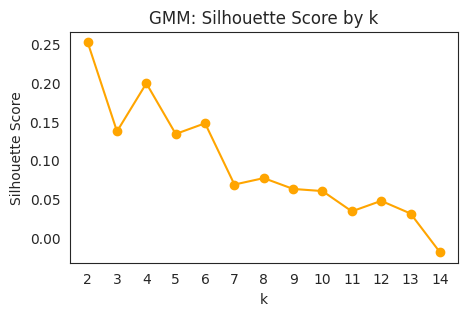

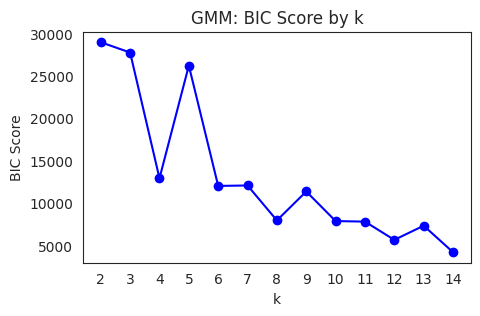

14

In [ ]:
# Silhouette score (higher = better)
best_k, silhouette_scores = find_k_sil_score(X_op, range(2, 15), model_name='GMM', random_state=2021)
# BIC (lower = better)
find_k_gmm_bic(X_op, range(2, 15), random_state=3242)

In [ ]:
# Pick the best random state
random_states = [42, 739, 2021, 10, 3242, 2, 4, 122]  # Example random states for initialization
n_components = 4 # Your optimal number of components

evaluations = evaluate_gmm_init(X_op, n_components, random_states)

# Analyzing results to find the best initialization based on chosen criteria
best_by_sil = max(evaluations, key=lambda x: x['silhouette_score'])
best_by_bic = min(evaluations, key=lambda x: x['bic'])

print("Best model by BIC:", best_by_bic)
print("Best model by sil:", best_by_sil)
#print("Evaluations:", evaluations)

Best model by BIC: {'random_state': 3242, 'average_probability': 0.9572412908403628, 'aic': 12447.538353183487, 'bic': 12935.550956095643, 'silhouette_score': 0.12307446159961727}
Best model by sil: {'random_state': 2021, 'average_probability': 0.8724764707788394, 'aic': 26889.059818847618, 'bic': 27377.072421759774, 'silhouette_score': 0.19952804297866236}


In [ ]:
n_components=4
labels, p = apply_gmm(X_op, n_components=n_components, random_state=2021) #  #10 #2021
df_op['cluster_gmm'] = labels
#df_lesserror['cluster_gmm'] = labels
df_final['cluster_gmm'] = labels
df_op.groupby('cluster_gmm').size()

cluster_gmm
0    546
1    969
2    937
3    191
dtype: int64

### 4.2 EDA

#### 4.2.1 Summary

In [ ]:
display(df_final.groupby('cluster_gmm')[op_cols].median())
display(df_final.groupby('cluster_gmm')['median_miles_per_trip'].median())
display(df_final.groupby('cluster_gmm')['tips_proportion'].median())
display(df_final.groupby('cluster_gmm')['record_error_rate'].median())

,idle_time,daily_use_rate,trips_per_day,daily_payment,avg_speed
cluster_gmm,,,,,
0,900.0,0.453311,13.0,359.1500,17.80265
1,1800.0,0.329395,9.0,208.7300,12.00000
2,3600.0,0.302824,5.0,211.2775,22.43575
3,2475.0,0.310339,6.0,179.9250,15.69015


cluster_gmm
0     8.6550
1     2.3250
2    13.1700
3     4.5075
Name: median_miles_per_trip, dtype: float64

cluster_gmm
0    0.169075
1    0.172134
2    0.166667
3    0.166667
Name: tips_proportion, dtype: float64

cluster_gmm
0    0.034664
1    0.018049
2    0.019475
3    0.032655
Name: record_error_rate, dtype: float64

#### 4.2.2 Scatter plots

In [ ]:
# Define a function to filter outliers
def filter_outliers(df, col_x, col_y):
    q1_x, q3_x = df[col_x].quantile(0.05), df[col_x].quantile(0.95)
    iqr_x = q3_x - q1_x
    lower_bound_x, upper_bound_x = q1_x - 1.5 * iqr_x, q3_x + 1.5 * iqr_x

    q1_y, q3_y = df[col_y].quantile(0.05), df[col_y].quantile(0.95)
    iqr_y = q3_y - q1_y
    lower_bound_y, upper_bound_y = q1_y - 1.5 * iqr_y, q3_y + 1.5 * iqr_y

    return df[(df[col_x] >= lower_bound_x) & (df[col_x] <= upper_bound_x) &
              (df[col_y] >= lower_bound_y) & (df[col_y] <= upper_bound_y)]


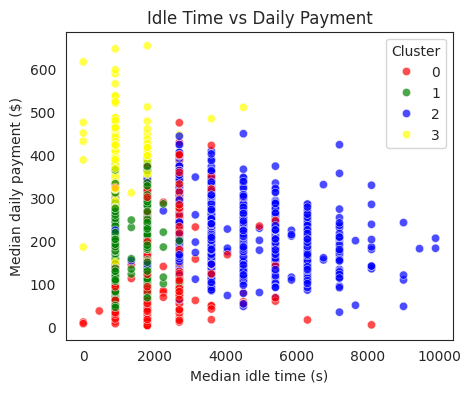

In [ ]:
# Set the seaborn style to white
sns.set_style("white")
custom_colors = ['red', 'green', 'blue', 'yellow']


# Filter outliers from the dataframe
filtered_df = filter_outliers(df_final, 'idle_time', 'daily_payment')

# Create a scatter plot with cluster colors
plt.figure(figsize=(5, 4))
sns.scatterplot(data=filtered_df, x='idle_time', y='daily_payment', hue='cluster_gmm', palette=custom_colors, alpha=0.7)
plt.title('Idle Time vs Daily Payment')
plt.xlabel('Median idle time (s)')
plt.ylabel('Median daily payment ($)')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)  # Add grid
plt.show()

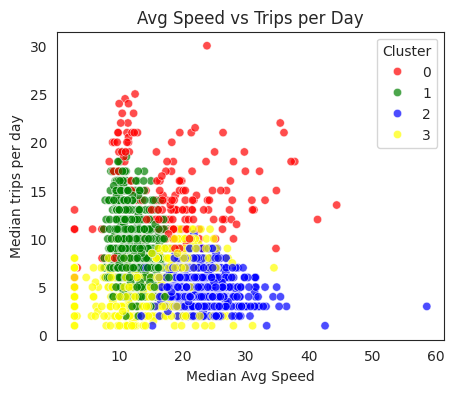

In [ ]:
# Set the seaborn style to white
sns.set_style("white")
custom_colors = ['red', 'green', 'blue', 'yellow']
filtered_df = filter_outliers(df_final, 'daily_use_rate', 'trips_per_day')
# Create a scatter plot with cluster colors
plt.figure(figsize=(5, 4))
sns.scatterplot(data=filtered_df, x='avg_speed', y='trips_per_day', hue='cluster_gmm', palette=custom_colors, alpha=0.7)
plt.title('Avg Speed vs Trips per Day')
plt.xlabel('Median Avg Speed')
plt.ylabel('Median trips per day')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)  # Add grid
plt.show()

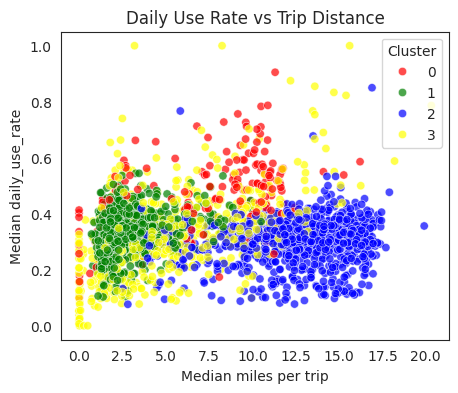

In [ ]:
# Set the seaborn style to white
sns.set_style("white")
custom_colors = ['red', 'green', 'blue', 'yellow']
filtered_df = filter_outliers(df_final, 'idle_time', 'avg_speed')
# Create a scatter plot with cluster colors
plt.figure(figsize=(5, 4))
sns.scatterplot(data=filtered_df, x='median_miles_per_trip', y='daily_use_rate', hue='cluster_gmm', palette=custom_colors, alpha=0.7)
plt.title('Daily Use Rate vs Trip Distance')
plt.ylabel('Median daily_use_rate')
plt.xlabel('Median miles per trip')
plt.legend(title='Cluster', loc='upper right')
plt.grid(False)  # Add grid
plt.show()

#### 4.2.3 Box plots

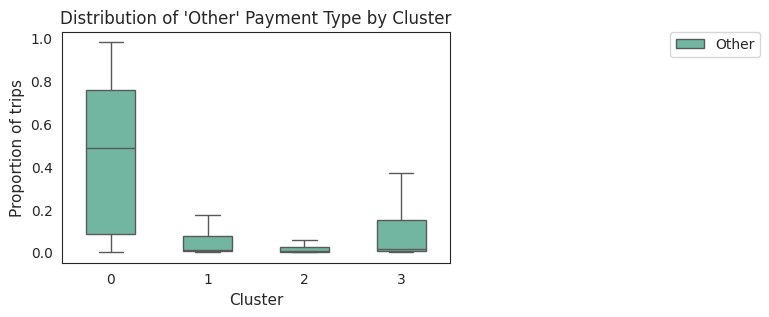

In [ ]:
# Melt the DataFrame to have a single column for payment type and a corresponding value column
melted_df = df_final.melt(id_vars='cluster_gmm', value_vars=['payment_type_other'], #'payment_type_credit_card',, 'payment_type_mobile','payment_type_cash'
                    var_name='payment_type', value_name='payment_value')

# Set the seaborn style to white
sns.set_style("white")

# Map payment_type to desired legend labels
payment_type_labels = {'payment_type_credit_card': 'Credit Card',
                       'payment_type_other': 'Other'} #'payment_type_mobile': 'Mobile','payment_type_cash': 'Cash'

# Create boxplots for each payment type and cluster
plt.figure(figsize=(5, 3))
sns.boxplot(data=melted_df, y='payment_value', x='cluster_gmm', hue='payment_type', palette='Set2', showfliers=False, width=0.5, dodge=1) #, orient='h')
plt.title("Distribution of 'Other' Payment Type by Cluster")
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Proportion of trips', fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [payment_type_labels[label] for label in labels]
plt.legend(handles, new_labels, title='', loc='upper right', bbox_to_anchor=(1.8, 1), borderaxespad=0.)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()


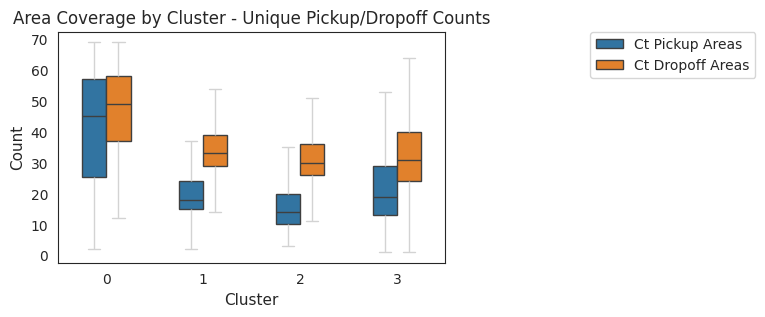

In [ ]:
# Melt the DataFrame to have a single column for payment type and a corresponding value column
melted_df = df_final.melt(id_vars='cluster_gmm', value_vars=['ct_pickup_ca','ct_dropoff_ca'], var_name='payment_type', value_name='payment_value')

# Set the seaborn style to white
sns.set_style("white")

# Map payment_type to desired legend labels
payment_type_labels = {'ct_pickup_ca': 'Ct Pickup Areas',
                       'ct_dropoff_ca': 'Ct Dropoff Areas'} #'payment_type_mobile': 'Mobile','payment_type_cash': 'Cash'

# Create boxplots for each payment type and cluster
plt.figure(figsize=(5, 3))
sns.boxplot(data=melted_df, y='payment_value', x='cluster_gmm', hue='payment_type', palette='tab10',
            showfliers=False, width=0.5, dodge=True,
            whiskerprops=dict(color="lightgrey", linewidth=1),
             capprops=dict(color="lightgrey", linewidth=1))

plt.title("Area Coverage by Cluster - Unique Pickup/Dropoff Counts")
plt.xlabel('Cluster', fontsize=11)
plt.ylabel('Count', fontsize=11)
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [payment_type_labels[label] for label in labels]
plt.legend(handles, new_labels, title='', loc='upper right', bbox_to_anchor=(1.8, 1), borderaxespad=0.)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.show()


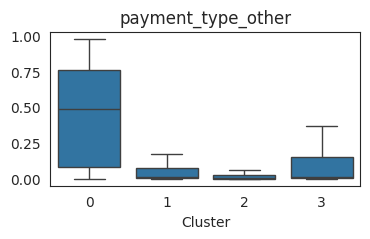

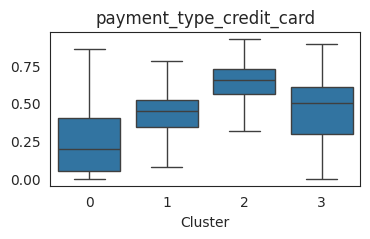

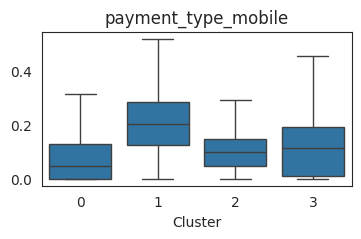

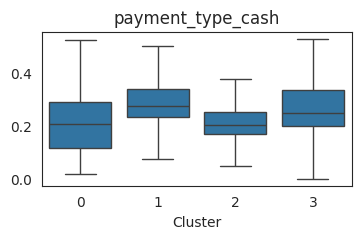

In [ ]:
boxplot(df_final, 'cluster_gmm', 'payment_type_other', title='payment_type_other',ylabel='', show_outliers=False)
boxplot(df_final, 'cluster_gmm', 'payment_type_credit_card', title='payment_type_credit_card',ylabel='', show_outliers=False)
boxplot(df_final, 'cluster_gmm', 'payment_type_mobile', title='payment_type_mobile',ylabel='', show_outliers=False)
boxplot(df_final, 'cluster_gmm', 'payment_type_cash', title='payment_type_cash',ylabel='', show_outliers=False)

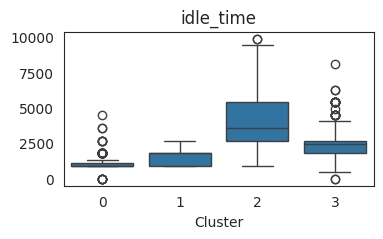

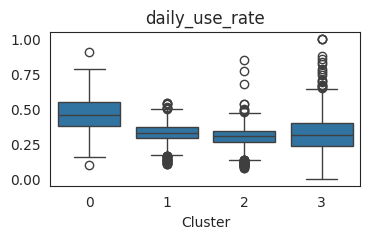

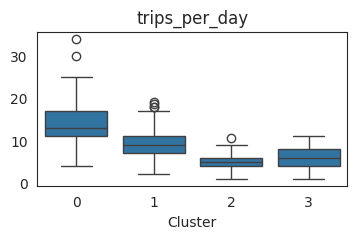

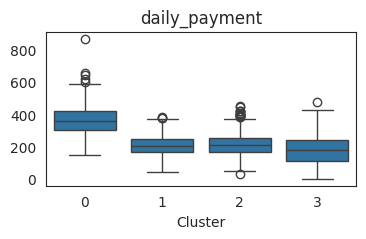

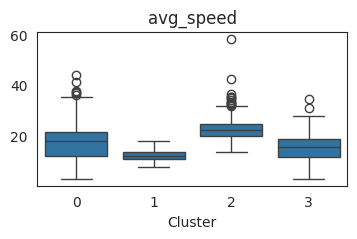

In [ ]:
for col in op_cols:
    #boxplot(df_lesserror, 'cluster_gmm', col, col, show_outliers=False)
    boxplot(df_final, 'cluster_gmm', col, col, show_outliers=True)

#### 4.2.4 Bar chart for slides

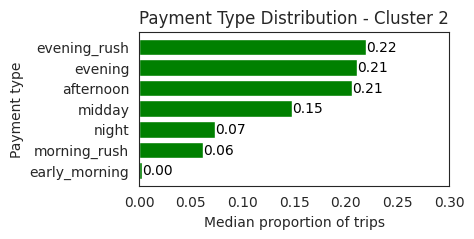

In [ ]:
def dist_bar_1c(df, cluster, col_list, col_prefix,max_xlim):
  # Filter the DataFrame to get data for cluster 2 only
  cluster_data = df[df['cluster_gmm'] == cluster]

  # Group by cluster and calculate median payment types
  median_cluster = cluster_data[col_list].median()
  median_cluster = median_cluster.sort_values(ascending=False)

  # Replace "payment_type_" with an empty string in the index
  median_cluster.index = median_cluster.index.str.replace(col_prefix, '')

  # Prepare data for plotting
  types = median_cluster.index
  values = median_cluster.values

  # Create bar graph
  plt.figure(figsize=(4, 2))
  bars = plt.barh(types, values, color='green')
  plt.xlabel('Median proportion of trips')
  plt.ylabel('Payment type')
  plt.title('Payment Type Distribution - Cluster 2')
  plt.xlim(0, max_xlim)  # Set the same x-axis range for all plots
  plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top

  # Add values at the end of each bar
  for bar, value in zip(bars, values):
      plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{value:.2f}',
              va='center', ha='left', color='black')
  plt.show()

dist_bar_1c(df_final, 2, time_cols, 'period_start_',0.3)

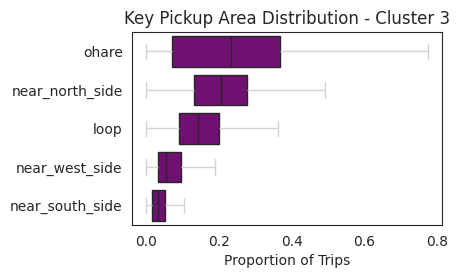

In [ ]:
col_list = ['pickup_ca_name_ohare','pickup_ca_name_near_north_side','pickup_ca_name_loop','pickup_ca_name_near_west_side','pickup_ca_name_near_south_side']
def dist_boxplot_1c(df, cluster, col_list, col_prefix, ylabel, title, color):
    # Filter the DataFrame to get data for the specified cluster
    cluster_data = df[df['cluster_gmm'] == cluster]

    # Prepare data for plotting
    melted_df = cluster_data.melt(value_vars=col_list) #, var_name='Payment Type', value_name='Proportion of Trips')

    # Replace "payment_type_" with an empty string in the column names
    melted_df['variable'] = melted_df['variable'].str.replace(col_prefix, '')

    # Sort the payment types by median proportion of trips (high to low)
    order = melted_df.groupby('variable')['value'].median().sort_values(ascending=False).index

    # Create boxplot
    plt.figure(figsize=(4, 2.5))
    sns.boxplot(data=melted_df, x='value', y='variable', color=color, order=order, showfliers=False,
                whiskerprops=dict(color="lightgrey", linewidth=1), capprops=dict(color="lightgrey", linewidth=1))
    plt.xlabel('Proportion of Trips')
    plt.ylabel(ylabel)
    plt.title(f'{title} - Cluster {cluster}')
    plt.grid(False)
    plt.show()

# Example usage
#dist_boxplot_1c(df_final, 2, pay_cols, 'payment_type_', '','Payment Type Distribution', 'green')
#dist_boxplot_1c(df_final, 1, time_cols, 'period_start_', '','Start Time Distribution','orange')
dist_boxplot_1c(df_final, 3, col_list, 'pickup_ca_name_', '','Key Pickup Area Distribution','purple')


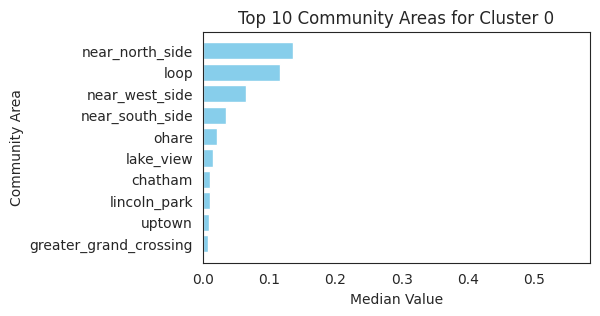

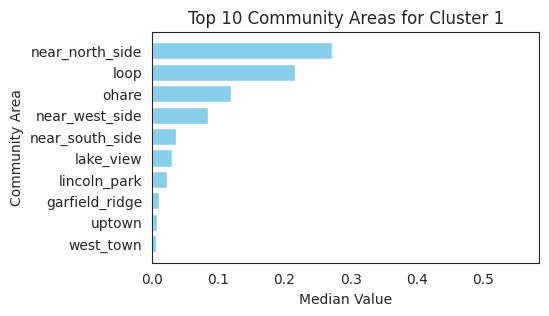

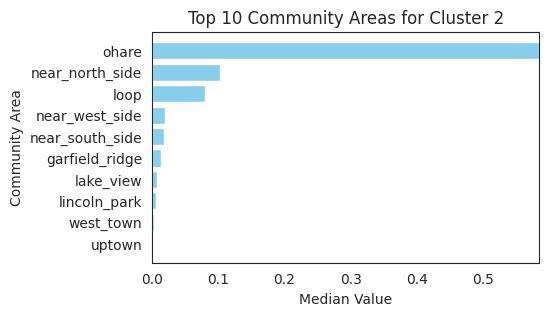

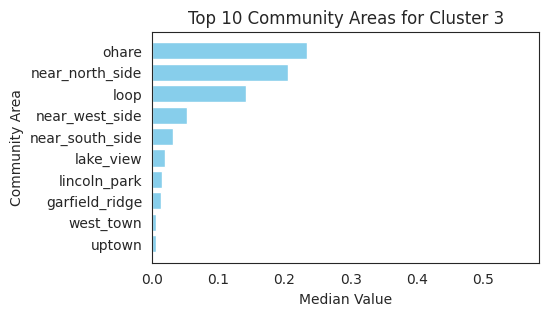

In [ ]:
# Apply the function to your dataset
ca_top_10 = top_ca_dict(df_final, 'cluster_gmm', ca_cols, 10)
# First, determine the maximum median value across all clusters
max_median_value = max(max(ca_dict.values()) for ca_dict in ca_top_10.values())

# Plotting the bar graphs for each cluster's top 10 CA columns with uniform x-axis
plot_top_ca(ca_top_10, max_median_value)

## **5. Hierarchical**

Calculating silhouette scores for different values of k...


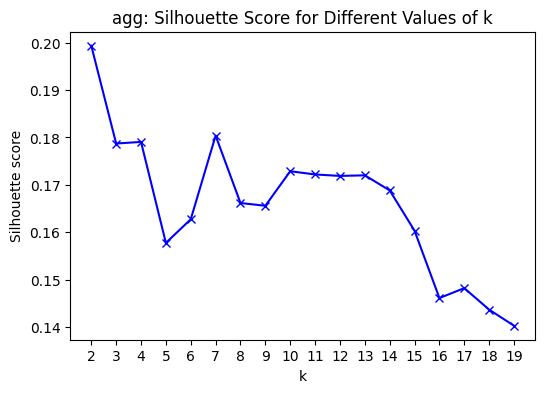

In [ ]:
best_k, silhouette_scores = find_k_sil_score(X_op, range(2, 20), model_name='agg')

In [ ]:
# Define the range of parameters to try
metrics = ['euclidean', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

# Define the optimal number of clusters (assuming you have determined this beforehand)
n_clusters = 3
# Evaluate clustering
results, best = evaluate_agg(X_op, n_clusters, metrics, linkages)

# Print the results
print("Evaluation Results (Metric, Linkage, Silhouette Score):")
for result in results:
    print(result)
print(f"\nBest combination: {best[0]}-{best[1]} with silhouette score: {best[2]}")

# Example usage
best_combination, best_score, best_balance = evaluate_with_balance(X_op, n_clusters, metrics, linkages)
print(f"Best combination: {best_combination} with combined score: {best_score}, balance: {best_balance}")

Evaluation Results (Metric, Linkage, Silhouette Score):
('euclidean', 'ward', 0.1787173531167753)
('euclidean', 'complete', 0.40977161921704985)
('euclidean', 'average', 0.6156989103534489)
('euclidean', 'single', 0.5151170609540172)
('manhattan', 'complete', 0.1648888401078596)
('manhattan', 'average', 0.4937596178841261)
('manhattan', 'single', 0.6487003061312961)
('cosine', 'complete', 0.33003129637691525)
('cosine', 'average', 0.3354148681468231)
('cosine', 'single', -0.17025235823050094)

Best combination: manhattan-single with silhouette score: 0.6487003061312961
Best combination: ('cosine', 'average') with combined score: 0.07693399616026904, balance: 0.5093984962406015


In [ ]:
best_k = 3
labels = apply_agglomerative(X_op, best_k, metric='cosine',linkage='complete') #complete
df_op['cluster_agg'] = labels
df_lesserror['cluster_agg'] = labels
df_op.groupby('cluster_agg').size()

cluster_agg
0    1063
1    1082
2     492
dtype: int64

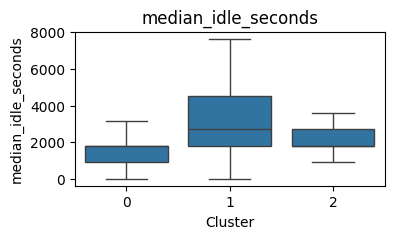

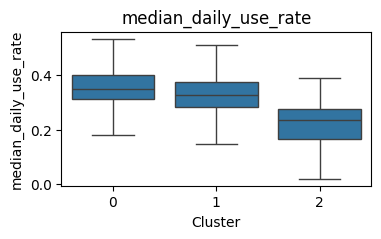

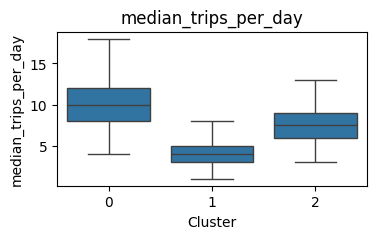

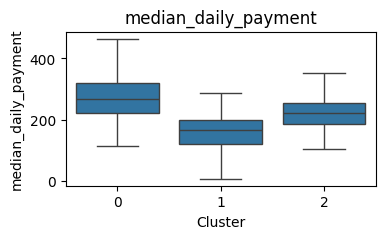

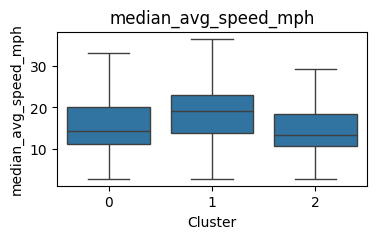

In [ ]:
for col in op_cols:
    boxplot(df_op, 'cluster_agg', col, col, show_outliers=False)

In [ ]:
display(df_op.groupby('cluster_agg')[op_cols].median())
display(df_lesserror.groupby('cluster_agg')['median_miles_per_trip'].median())

,median_idle_seconds,median_daily_use_rate,median_trips_per_day,median_daily_payment,median_avg_speed_mph
cluster_agg,,,,,
0,1800.0,0.348639,10.0,267.555,14.32430
1,2700.0,0.327536,4.0,166.485,19.04925
2,1800.0,0.234370,7.5,221.690,13.32990


cluster_agg
0     3.900
1    10.015
2     2.910
Name: median_miles_per_trip, dtype: float64

In [ ]:
compare_table(df_lesserror, 'cluster_agg')

KeyError: 'cluster_agg'

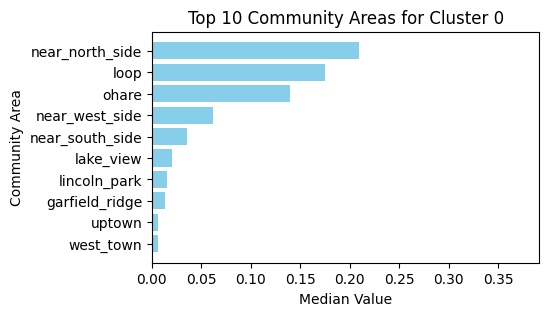

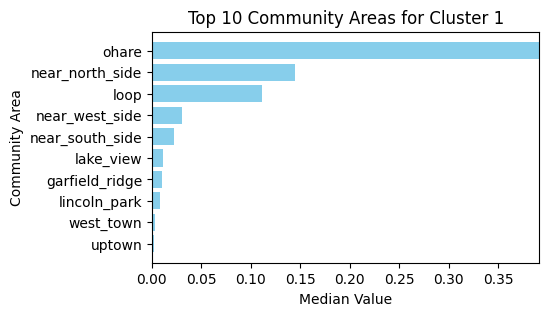

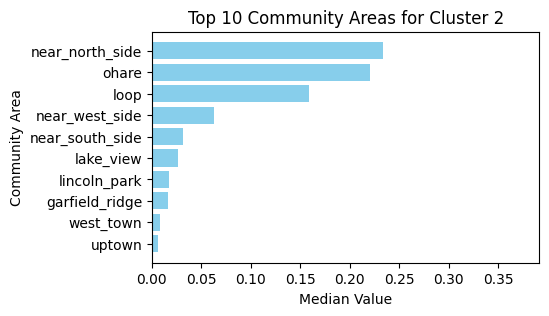

In [ ]:
# Apply the function to your dataset
ca_top_10 = top_ca_dict(df_lesserror, 'cluster_agg', ca_cols, 10)
# First, determine the maximum median value across all clusters
max_median_value = max(max(ca_dict.values()) for ca_dict in ca_top_10.values())

# Plotting the bar graphs for each cluster's top 10 CA columns with uniform x-axis
plot_top_ca(ca_top_10, max_median_value)

## **6. HDBSCAN**

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
# Calculate the cosine distance matrix
cosine_dist_matrix = cosine_distances(X_op)

def apply_hdbscan(X, min_cluster_size=50, metric='euclidean', algorithm='auto', min_samples=2):
    if min_samples is None:
        min_samples = min_cluster_size
    cluster = HDBSCAN(min_cluster_size=min_cluster_size,
                        min_samples=min_samples,
                        metric=metric,
                        algorithm=algorithm,
                        cluster_selection_method='eom')
    labels = cluster.fit_predict(X)
    return labels  # Return labels directly for precomputed distances

# Apply HDBSCAN
#labels = apply_hdbscan(cosine_dist_matrix, min_cluster_size=50, metric='precomputed', min_samples=2)
labels = apply_hdbscan(X_op, min_cluster_size=50, metric='euclidean', min_samples=2)

# Assign labels back to the original DataFrame
df_op['cluster_hdbscan'] = labels
df_lesserror['cluster_hdbscan'] = labels
df_op['cluster_hdbscan'].value_counts()

 0    1810
-1     622
 1     229
Name: cluster_hdbscan, dtype: int64